<a href="https://colab.research.google.com/github/vadhri/distibuted-optimization/blob/main/AugmentedLagrangian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

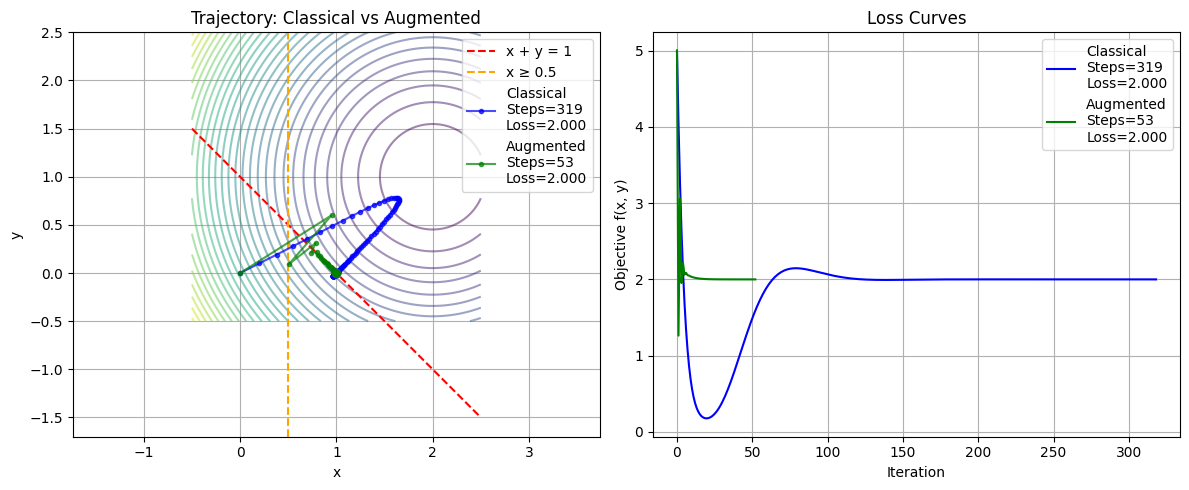

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Objective
def f(x):
    return (x[0] - 2)**2 + (x[1] - 1)**2

# Equality and inequality constraints
def g(x): return x[0] + x[1] - 1
def h(x): return 0.5 - x[0]

# Classical Lagrangian
def L(x, lam): return f(x) + lam * g(x)

def solve_classical_lagrangian_gd(x0, lam0=0.0, lr=0.05, max_iter=500, tol=1e-7):
    x, lam = x0.copy(), lam0
    traj, losses, std_window = [x.copy()], [f(x)], []
    for _ in range(max_iter):
        grad_x = np.zeros_like(x)
        eps = 1e-6
        for j in range(len(x)):
            x_eps = x.copy()
            x_eps[j] += eps
            grad_x[j] = (L(x_eps, lam) - L(x, lam)) / eps
        grad_lam = g(x)

        x -= lr * grad_x
        lam += lr * grad_lam

        loss = f(x)
        traj.append(x.copy())
        losses.append(loss)
        std_window.append(loss)
        if len(std_window) > 10:
            std_window.pop(0)
            if np.std(std_window) < tol:
                break
    return x, lam, np.array(traj), losses

# Augmented Lagrangian
def augmented_lagrangian(x, lam, mu, rho):
    penalty = lam * g(x) + 0.5 * rho * g(x)**2
    if h(x) > 0:
        penalty += mu * h(x) + 0.5 * rho * h(x)**2
    return f(x) + penalty

def optimize_augmented_lagrangian(x0, lam=0.0, mu=0.0, rho=10.0, max_iter=100, eta=0.05, tol=1e-5):
    x = x0.copy()
    trajectory, losses, std_window = [x.copy()], [f(x)], []
    for _ in range(max_iter):
        grad = np.zeros_like(x)
        eps = 1e-6
        for i in range(len(x)):
            x_eps = x.copy()
            x_eps[i] += eps
            grad[i] = (augmented_lagrangian(x_eps, lam, mu, rho) - augmented_lagrangian(x, lam, mu, rho)) / eps
        x -= eta * grad

        lam += rho * g(x)
        mu = max(0, mu + rho * h(x))

        loss = f(x)
        trajectory.append(x.copy())
        losses.append(loss)

        std_window.append(loss)
        if len(std_window) > 10:
            std_window.pop(0)
            if np.std(std_window) < tol:
                break
    return x, lam, np.array(trajectory), losses

# --- Run both methods ---
x0 = np.array([0.0, 0.0])
x_classical, lam_classical, traj_classical, loss_classical = solve_classical_lagrangian_gd(x0)
x_aug, lam_aug, traj_aug, loss_aug = optimize_augmented_lagrangian(x0)

# --- Plot ---
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Trajectory
X, Y = np.meshgrid(np.linspace(-0.5, 2.5, 200), np.linspace(-0.5, 2.5, 200))
Z = (X - 2)**2 + (Y - 1)**2
ax[0].contour(X, Y, Z, levels=30, cmap='viridis', alpha=0.5)

x_line = np.linspace(-0.5, 2.5, 200)
ax[0].plot(x_line, 1 - x_line, 'r--', label='x + y = 1')
ax[0].axvline(0.5, color='orange', linestyle='--', label='x ≥ 0.5')

ax[0].plot(traj_classical[:, 0], traj_classical[:, 1], 'b.-', alpha=0.7,
           label=f'Classical\nSteps={len(loss_classical)}\nLoss={loss_classical[-1]:.3f}')
ax[0].plot(traj_aug[:, 0], traj_aug[:, 1], 'g.-', alpha=0.7,
           label=f'Augmented\nSteps={len(loss_aug)}\nLoss={loss_aug[-1]:.3f}')

ax[0].plot(*traj_classical[-1], 'bo')
ax[0].plot(*traj_aug[-1], 'go')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Trajectory: Classical vs Augmented')
ax[0].legend()
ax[0].grid(True)
ax[0].axis('equal')

# Plot 2: Loss curves
ax[1].plot(loss_classical, 'b-', label=f'Classical\nSteps={len(loss_classical)}\nLoss={loss_classical[-1]:.3f}')
ax[1].plot(loss_aug, 'g-', label=f'Augmented\nSteps={len(loss_aug)}\nLoss={loss_aug[-1]:.3f}')
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Objective f(x, y)")
ax[1].set_title("Loss Curves")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


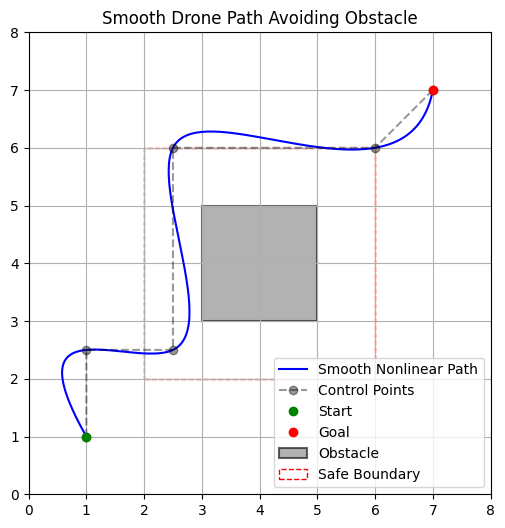

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.interpolate import splprep, splev

# Start and Goal
start = np.array([1, 1])
goal = np.array([7, 7])

# Obstacle Parameters
obstacle_center = np.array([4, 4])
obstacle_size = 2
buffer = 1.0  # clearance buffer

# Define safe control points around the obstacle buffer
ctrl_pts = np.array([
    start,
    [1, 2.5],
    [2.5, 2.5],
    [2.5, 6],
    [6, 6],
    goal
])

# Fit B-spline to control points
tck, u = splprep([ctrl_pts[:, 0], ctrl_pts[:, 1]], s=0)
u_fine = np.linspace(0, 1, 200)
x_smooth, y_smooth = splev(u_fine, tck)

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x_smooth, y_smooth, 'b-', label="Smooth Nonlinear Path")
ax.plot(ctrl_pts[:, 0], ctrl_pts[:, 1], 'ko--', alpha=0.4, label="Control Points")
ax.plot(*start, 'go', label="Start")
ax.plot(*goal, 'ro', label="Goal")

# Obstacle and buffer
obs_half = obstacle_size / 2
buffer_half = obs_half + buffer
obstacle_main = Rectangle(obstacle_center - obs_half, obstacle_size, obstacle_size,
                          linewidth=1.5, edgecolor='k', facecolor='gray', alpha=0.6, label="Obstacle")
obstacle_buffer = Rectangle(obstacle_center - buffer_half,
                            obstacle_size + 2*buffer, obstacle_size + 2*buffer,
                            linewidth=1, edgecolor='r', facecolor='none', linestyle='--', label="Safe Boundary")

ax.add_patch(obstacle_main)
ax.add_patch(obstacle_buffer)

# Display settings
ax.set_xlim(0, 8)
ax.set_ylim(0, 8)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
ax.set_title("Smooth Drone Path Avoiding Obstacle")
plt.show()


In [ ]:
np.linalg.norm([(1,1)] - target), np.sqrt(72)

(np.float64(8.48528137423857), np.float64(8.48528137423857))

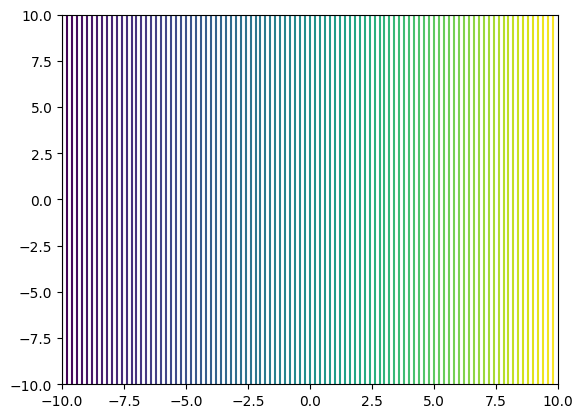

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# function x
def f(x, y):
  return x

def gradf(x,y):
  return 1

#plot a grid with x,y
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

#plot the function f(x,y)
plt.contour(X, Y, Z, levels=100)
plt.show()


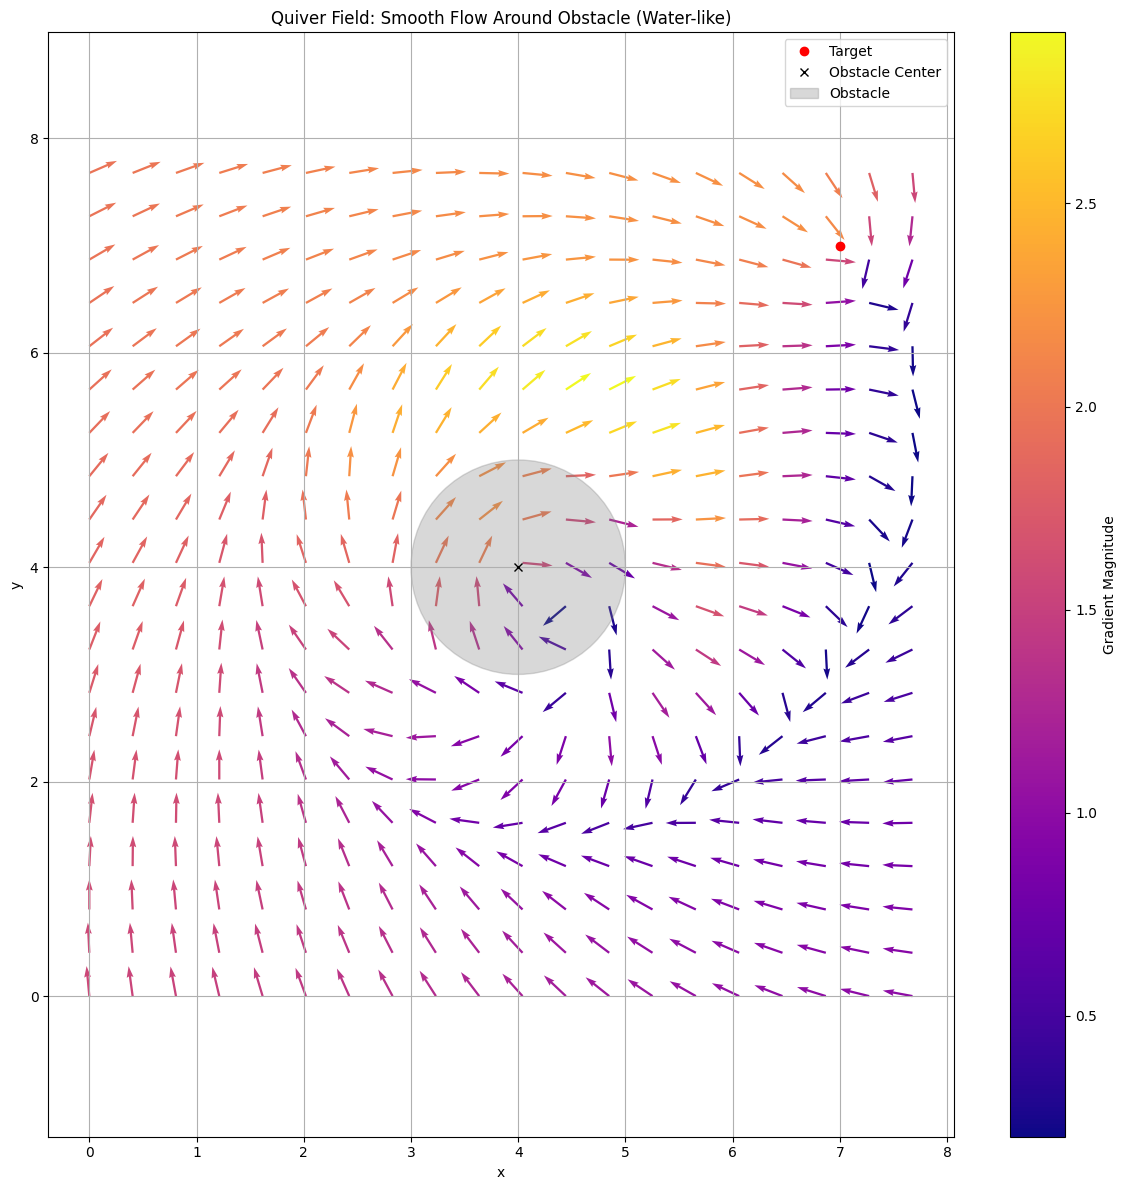

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Grid
x = np.linspace(0, 8, 100)
y = np.linspace(0, 8, 100)
X, Y = np.meshgrid(x, y)

# Parameters
obstacle_center = np.array([4.0, 4.0])
obstacle_radius = 1.0
target = np.array([7.0, 7.0])
sigma = 0.8
swirl_strength = 0.6

# Gradients
def objective_grad(x):
    diff = x - target
    return diff / (np.linalg.norm(diff) + 1e-8)

def truncated_phi(x):
    dist = np.linalg.norm(x - obstacle_center)
    if dist <= obstacle_radius:
        return 0.0
    return np.exp(-((dist - obstacle_radius)**2) / (2 * sigma**2))

def truncated_phi_grad(x):
    diff = x - obstacle_center
    dist = np.linalg.norm(diff)
    if dist <= obstacle_radius or dist == 0.0:
        return np.zeros_like(x)
    phi = truncated_phi(x)
    return phi * (obstacle_radius - dist) / (sigma**2 * dist + 1e-8) * diff

def swirl_vector(x, strength=1.0):
    diff = x - obstacle_center
    norm = np.linalg.norm(diff)
    if norm == 0:
        return np.zeros_like(x)
    return strength * np.array([-diff[1], diff[0]]) / (norm + 1e-8)

# Field computation
U, V = np.zeros_like(X), np.zeros_like(Y)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pos = np.array([X[i, j], Y[i, j]])
        grad = (
            objective_grad(pos)
            + 2*truncated_phi_grad(pos)
            + 2*swirl_vector(pos, swirl_strength)
        )
        U[i, j], V[i, j] = -grad

# Normalize
mag = np.sqrt(U**2 + V**2)
U_norm = U / (mag + 1e-8)
V_norm = V / (mag + 1e-8)

# Plot
plt.figure(figsize=(12, 12))
skip = 5
plt.quiver(X[::skip, ::skip], Y[::skip, ::skip],
           U_norm[::skip, ::skip], V_norm[::skip, ::skip],
           mag[::skip, ::skip], cmap='plasma',
           scale=30, scale_units='width', width=0.0025)

plt.plot(*target, 'ro', label='Target')
plt.plot(*obstacle_center, 'kx', label='Obstacle Center')
obs = plt.Circle(obstacle_center, obstacle_radius, color='gray', alpha=0.3, label='Obstacle')
plt.gca().add_patch(obs)
plt.colorbar(label='Gradient Magnitude')
plt.title("Quiver Field: Smooth Flow Around Obstacle (Water-like)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


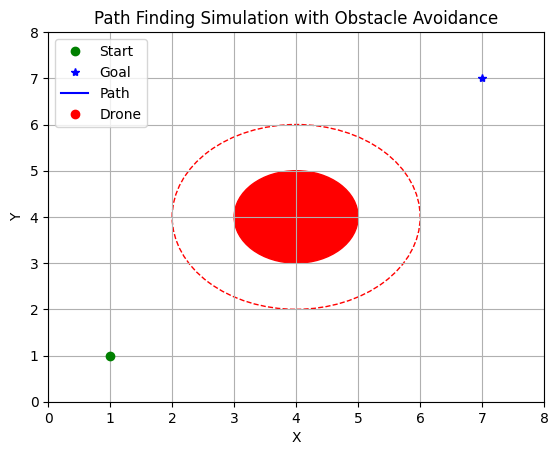

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Define the start and goal points
start = np.array([1.0, 1.0])
goal = np.array([7.0, 7.0])

# Define the obstacle (center and radius)
obstacle_center = np.array([4.0, 4.0])
obstacle_radius = 1.0
safety_distance = 1.0  # Additional distance to maintain from obstacle

# Parameters for the simulation
learning_rate = 0.1
max_iterations = 1000
tolerance = 1e-3

# Potential field functions
def attractive_potential(x, goal, k=1.0):
    """Calculate attractive potential towards the goal."""
    return 0.5 * k * np.linalg.norm(x - goal)**2

def repulsive_potential(x, obstacle_center, obstacle_radius, safety_distance, k=1.0):
    """Calculate repulsive potential from the obstacle."""
    dist = np.linalg.norm(x - obstacle_center)
    effective_radius = obstacle_radius + safety_distance
    if dist <= effective_radius:
        if dist == 0:  # Avoid division by zero
            return float('inf')
        return 0.5 * k * (1.0 / dist - 1.0 / effective_radius)**2
    return 0

def total_potential(x, goal, obstacle_center, obstacle_radius, safety_distance):
    """Calculate total potential."""
    return attractive_potential(x, goal) + repulsive_potential(x, obstacle_center, obstacle_radius, safety_distance)

# Gradient of potential field
def attractive_gradient(x, goal, k=1.0):
    """Gradient of attractive potential."""
    return k * (x - goal)

def repulsive_gradient(x, obstacle_center, obstacle_radius, safety_distance, k=1.0):
    """Gradient of repulsive potential."""
    dist = np.linalg.norm(x - obstacle_center)
    effective_radius = obstacle_radius + safety_distance
    if dist <= effective_radius:
        if dist == 0:
            return np.array([0.0, 0.0])
        direction = (x - obstacle_center) / dist
        return k * (1.0 / dist - 1.0 / effective_radius) * (1.0 / dist**2) * direction
    return np.array([0.0, 0.0])

def total_gradient(x, goal, obstacle_center, obstacle_radius, safety_distance):
    """Total gradient of the potential field."""
    return attractive_gradient(x, goal) + repulsive_gradient(x, obstacle_center, obstacle_radius, safety_distance)

# Hessian for Newton's method (simplified for demonstration)
def total_hessian(x, goal, obstacle_center, obstacle_radius, safety_distance, k_attr=1.0, k_rep=1.0):
    """Approximate Hessian matrix for Newton's method."""
    dist = np.linalg.norm(x - obstacle_center)
    effective_radius = obstacle_radius + safety_distance
    hessian = np.eye(2) * k_attr  # Attractive part
    if dist <= effective_radius and dist != 0:
        direction = (x - obstacle_center) / dist
        outer_product = np.outer(direction, direction)
        scalar = k_rep * (1.0 / dist - 1.0 / effective_radius) * (2.0 / dist**3) + k_rep * (1.0 / dist**2)
        hessian += scalar * outer_product
    return hessian

# Path finding using gradient descent with Newton's method
def find_path(start, goal, obstacle_center, obstacle_radius, safety_distance):
    """Find path using gradient descent with Newton's method."""
    x = start.copy()
    path = [x.copy()]

    for i in range(max_iterations):
        grad = total_gradient(x, goal, obstacle_center, obstacle_radius, safety_distance)
        if np.linalg.norm(grad) < tolerance:
            break

        hessian = total_hessian(x, goal, obstacle_center, obstacle_radius, safety_distance)
        try:
            step = np.linalg.solve(hessian, -grad)
        except np.linalg.LinAlgError:
            step = -learning_rate * grad

        x += learning_rate * step
        path.append(x.copy())

        if np.linalg.norm(x - goal) < tolerance:
            break

    return np.array(path)

# Simulate the path
path = find_path(start, goal, obstacle_center, obstacle_radius, safety_distance)

# Visualization
fig, ax = plt.subplots()
ax.set_xlim(0, 8)
ax.set_ylim(0, 8)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Path Finding Simulation with Obstacle Avoidance')

# Plot obstacle
circle = plt.Circle(obstacle_center, obstacle_radius, color='r', fill=True)
safety_circle = plt.Circle(obstacle_center, obstacle_radius + safety_distance, color='r', fill=False, linestyle='--')
ax.add_artist(circle)
ax.add_artist(safety_circle)

# Plot start and goal
ax.plot(start[0], start[1], 'go', label='Start')
ax.plot(goal[0], goal[1], 'b*', label='Goal')

# Plot path
line, = ax.plot([], [], 'b-', label='Path')
drone, = ax.plot([], [], 'ro', label='Drone')

def init():
    line.set_data([], [])
    drone.set_data([], [])
    return line, drone

def update(frame):
    line.set_data(path[:frame+1, 0], path[:frame+1, 1])
    drone.set_data(path[frame, 0], path[frame, 1])
    return line, drone

ani = FuncAnimation(fig, update, frames=len(path), init_func=init, blit=True, interval=50)

ax.legend()
plt.grid(True)
plt.show()
